# ETH/USDT Prediction Model using Auto Regression Integrated Moving Averages(ARIMA) Model

Objective: The objective of this task is to analyze historical Ethereum (ETH/USDT) price data using Autoregressive Integrated Moving Average (ARIMA) models. Time series analysis focuses on understanding data points ordered in time, identifying underlying patterns such as trends, seasonality, and cyclic behavior. ARIMA models combine autoregression (AR), differencing (I), and moving averages (MA) to capture these patterns and make reliable forecasts. The goal is to leverage this method to predict future prices and volatility in Ethereum’s market, providing data-driven insights that support strategic decision-making and enhance our understanding of cryptocurrency market dynamics.


### Step 1: Installing required libraries

- Numpy
- Pandas
- Matplotlib
- Seaborn
- Stats Models
- Scipy
- Requests
- Python Binance

Install from requirements file

In [4]:
%pip install -r requirements.txt

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   -------------------------------

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ------------------------- -------------- 6.3/9.9 MB 34.1 kB/s eta 0:01:45
   ------------------------- -------------- 6.3/9.9 MB 34.1 kB/s eta 0:01:45
   ------------------------- -------------- 6.3/9.9 MB 34.1 kB/s eta 0:01:45
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26
   -------------------------- ------------- 6.6/9.9 MB 38.8 kB/s eta 0:01:26

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from binance.client import Client
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


### Step 2: Data Collection and Preparation

Fetching Data using BINANCE API and storing in a CSV File

In [2]:
def read_file(filename):
    with open(filename , 'r') as file:
        text = file.read()
    
    return text

In [3]:
api_key = read_file("api.txt")
api_secret = read_file("api_secretkey.txt")
client = Client(api_key, api_secret)

# Fetch historical kline data
symbol = 'ETHUSDT'
interval = Client.KLINE_INTERVAL_1DAY # replace interval with required interval i.e. 1HOUR, 1MONTH etc
start_str = "1 Jan, 2020"

klines = client.get_historical_klines(symbol, interval, start_str)

We only select the necessary columns for our model because unnecessary can interfare in performance of model. For example Number of Trades is irrelevant to determine price of Etherium.

In [4]:
eth_data = pd.DataFrame(klines, columns=[
    "timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "num_trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
])

# Keep only needed columns
eth_data = eth_data[["timestamp", "open", "high", "low", "close", "volume"]]
eth_data["timestamp"] = pd.to_datetime(eth_data["timestamp"], unit='ms')
eth_data.set_index("timestamp", inplace=True)

# Convert prices to float
for col in ["open", "high", "low", "close", "volume"]:
    eth_data[col] = eth_data[col].astype(float)

# Save to CSV
eth_data.to_csv("ethusdt_daily.csv")

In [2]:
eth_data = pd.read_csv("ethusdt_daily.csv", index_col="timestamp", parse_dates=True)

In [3]:
print(eth_data.shape)
print(eth_data.info())

(1998, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1998 entries, 2020-01-01 to 2025-06-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1998 non-null   float64
 1   high    1998 non-null   float64
 2   low     1998 non-null   float64
 3   close   1998 non-null   float64
 4   volume  1998 non-null   float64
dtypes: float64(5)
memory usage: 93.7 KB
None


In [6]:
eth_data.columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

In [7]:
eth_data.head()

,open,high,low,close,volume
timestamp,,,,,
2020-01-01,129.16,133.05,128.68,130.77,144770.52197
2020-01-02,130.72,130.78,126.38,127.19,213757.05806
2020-01-03,127.19,135.14,125.88,134.35,413055.18895
2020-01-04,134.37,135.85,132.50,134.20,184276.17102
2020-01-05,134.20,138.19,134.19,135.37,254120.45343


Preprocessing


In [8]:
print(eth_data.isnull().sum())

# No null values in the dataset

open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [4]:
# adding price change and daily return columns
eth_data["price_change"] = eth_data["close"] - eth_data["open"]
eth_data["daily_return"] = eth_data["close"].pct_change()

In [5]:
#Check Time Gaps or Missing Days
expected_dates = pd.date_range(start=eth_data.index.min(), end=eth_data.index.max(), freq='D')
missing = expected_dates.difference(eth_data.index)
print("Missing dates:", missing)

# No missing day in the dataset

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [6]:
eth_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1998 entries, 2020-01-01 to 2025-06-20
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          1998 non-null   float64
 1   high          1998 non-null   float64
 2   low           1998 non-null   float64
 3   close         1998 non-null   float64
 4   volume        1998 non-null   float64
 5   price_change  1998 non-null   float64
 6   daily_return  1997 non-null   float64
dtypes: float64(7)
memory usage: 124.9 KB


### Step 3: Exploratory Data Analysis (EDA)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

Close Price vs Time


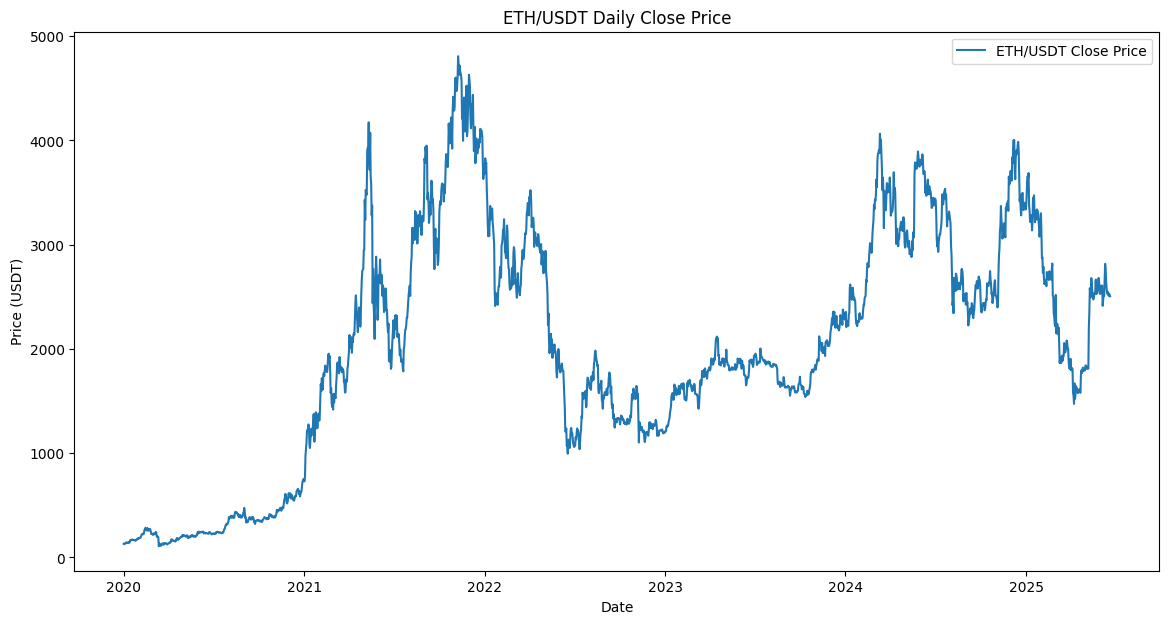

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(eth_data.index, eth_data['close'], label='ETH/USDT Close Price')
plt.title('ETH/USDT Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.savefig('graphs/ethusdt_daily_close_price.png')
plt.show()


Using only data of 2023 for graphs

In [8]:
eth_data_2023 = eth_data.loc["2023-01-01":"2023-12-31"]

Price trend over time

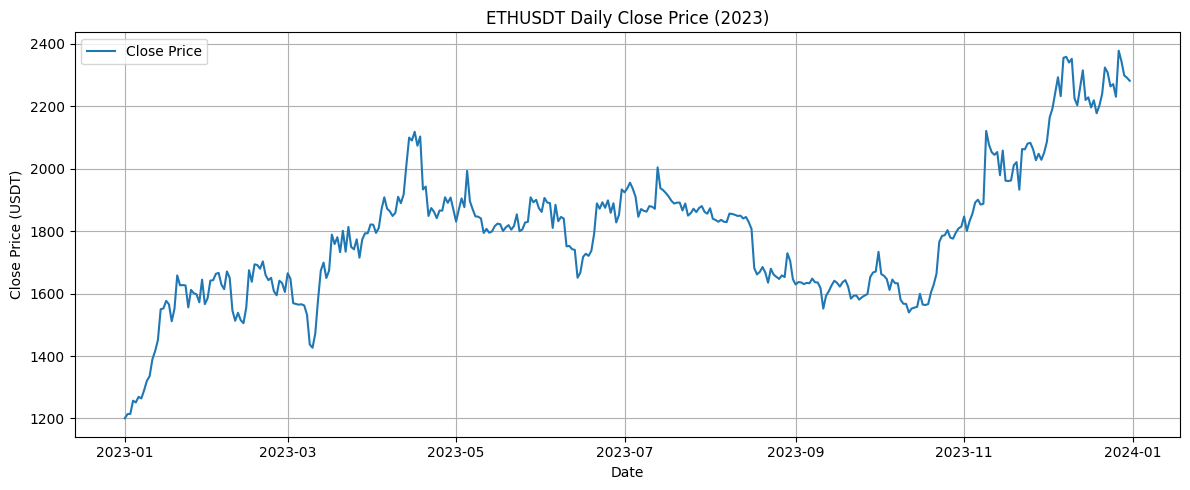

In [14]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=eth_data_2023, x=eth_data_2023.index, y='close', label='Close Price')
plt.title('ETHUSDT Daily Close Price (2023)')
plt.xlabel('Date')
plt.ylabel('Close Price (USDT)')
plt.grid(True)
plt.tight_layout()
plt.savefig("graphs/eth_close_price_2023.png")
plt.show()


Rolling Averages (7 days and 30 days)


In [ ]:
eth_data_2023["7_rolling"] = eth_data_2023["close"].rolling(window=7).mean()
eth_data_2023["30_rolling"] = eth_data_2023["close"].rolling(window=30).mean()

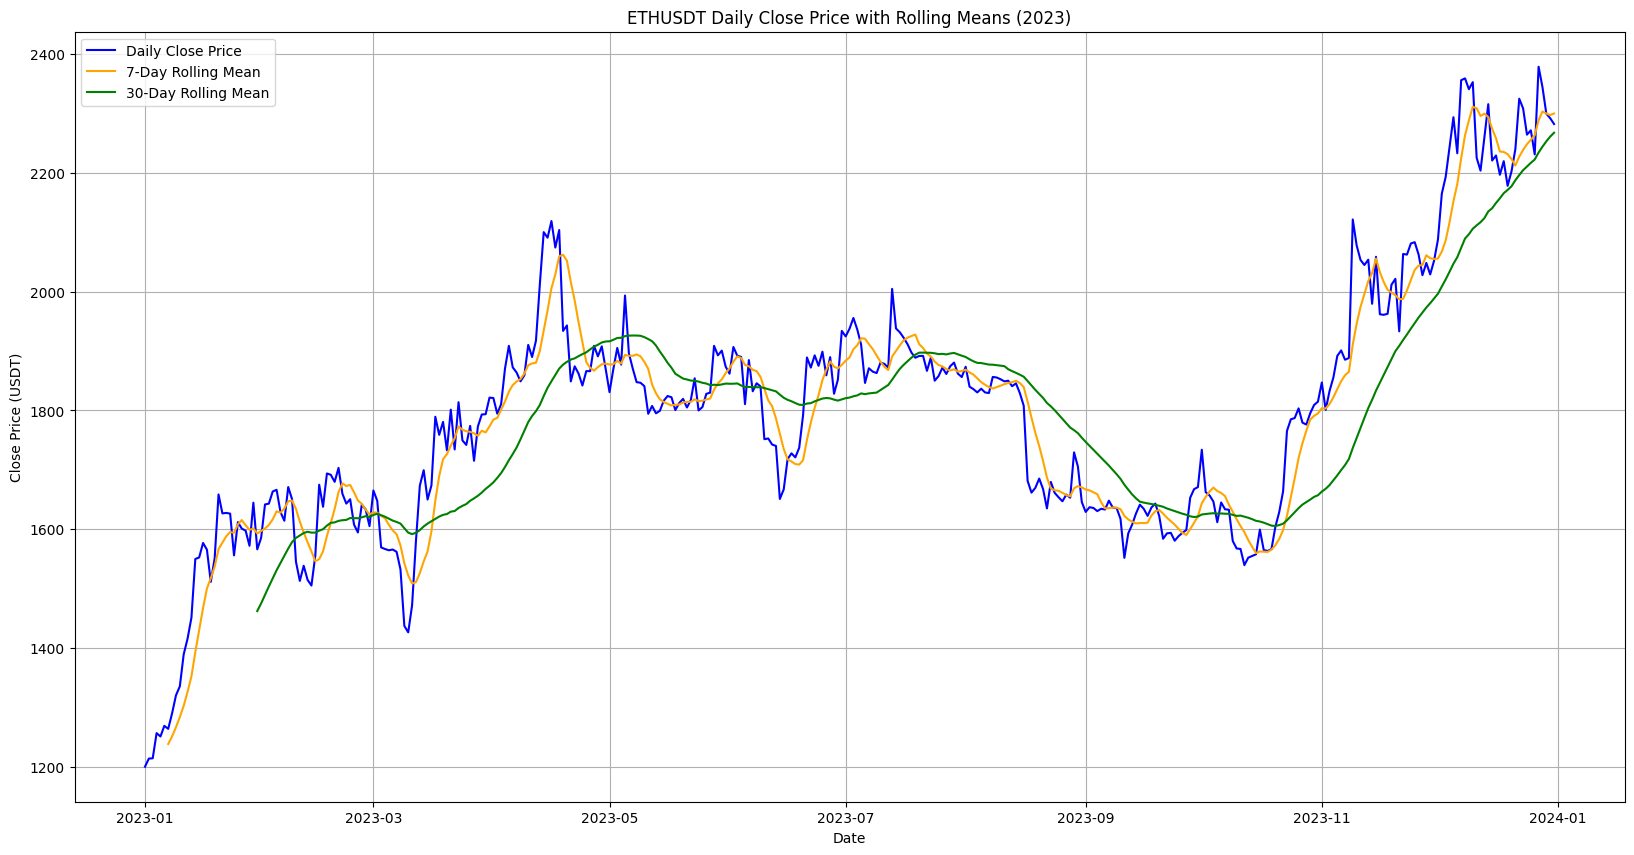

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(eth_data_2023["close"], label='Daily Close Price', color='blue')
plt.plot(eth_data_2023["7_rolling"], label='7-Day Rolling Mean', color='orange')
plt.plot(eth_data_2023["30_rolling"], label='30-Day Rolling Mean', color='green')
plt.title('ETHUSDT Daily Close Price with Rolling Means (2023)')
plt.xlabel("Date")
plt.ylabel("Close Price (USDT)")
plt.legend()
plt.grid(True)
plt.savefig("graphs/eth_rolling_averages_2023.png")
plt.show()


Trading Volume



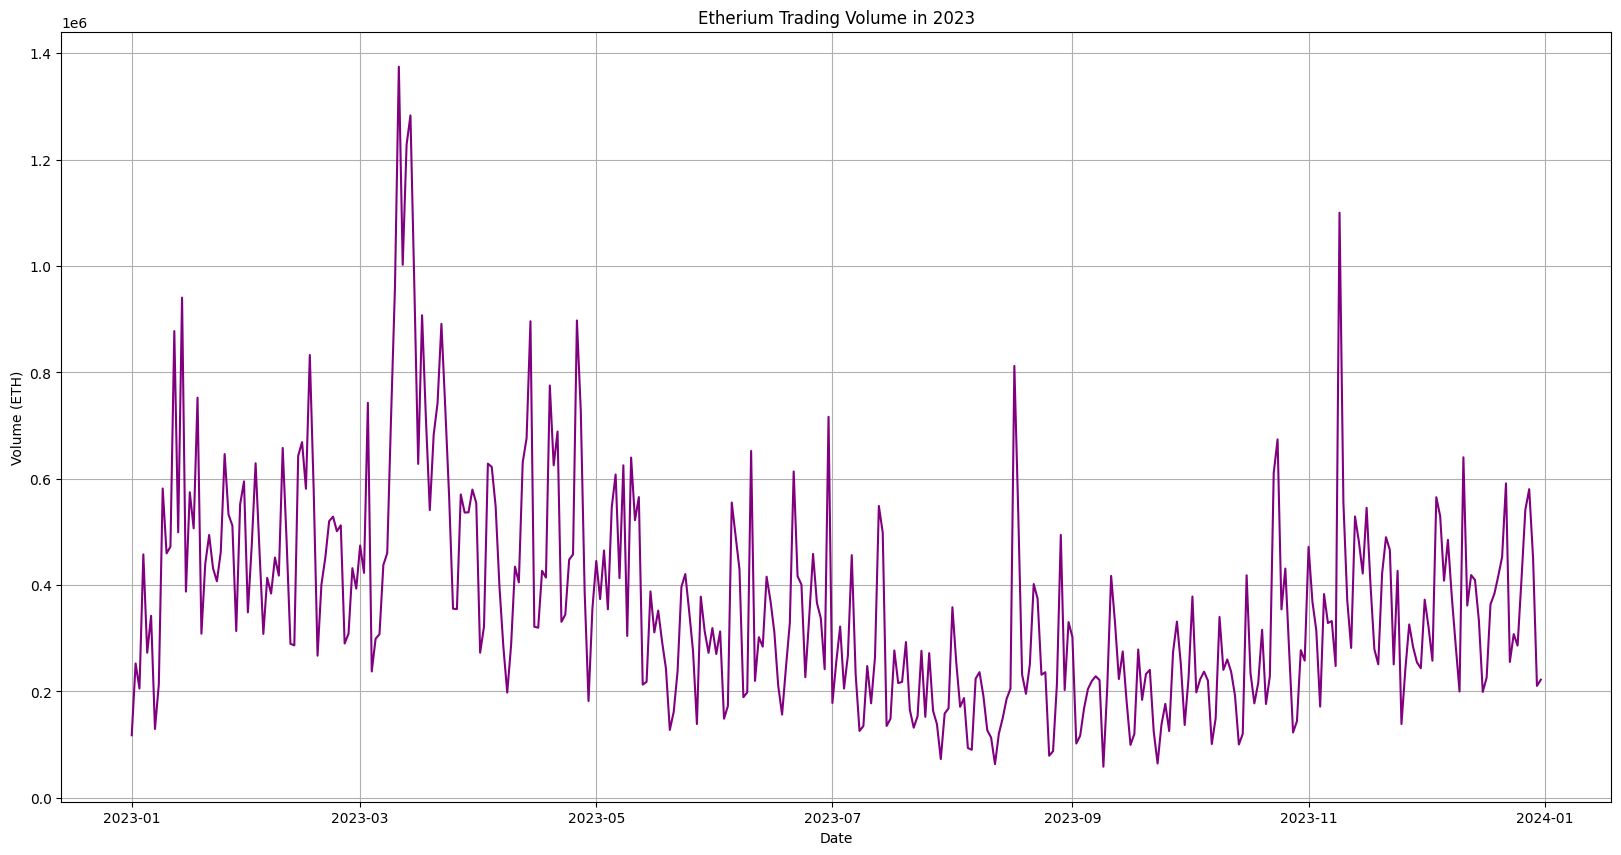

In [17]:
plt.figure(figsize=(20,10))
plt.plot(eth_data_2023["volume"] , color ="purple")
plt.title("Etherium Trading Volume in 2023")
plt.xlabel("Date")
plt.ylabel("Volume (ETH)")
plt.grid(True)
plt.savefig("graphs/eth_volume_2023.png")
plt.show()

Daily Returns (2023)

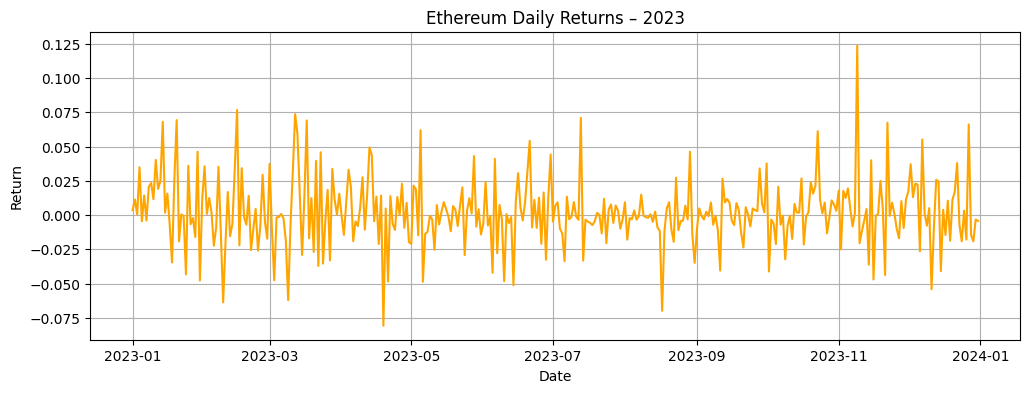

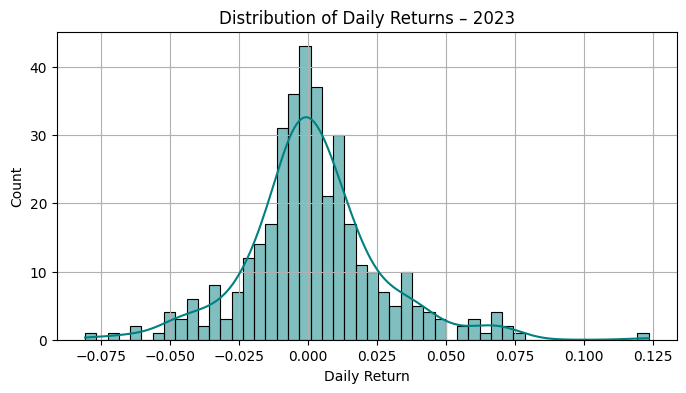

In [18]:
plt.figure(figsize=(12,4))
plt.plot(eth_data_2023["daily_return"], color="orange")
plt.title("Ethereum Daily Returns – 2023")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.savefig("graphs/eth_daily_returns_2023.png")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(eth_data_2023["daily_return"].dropna(), bins=50, kde=True, color='teal')
plt.title("Distribution of Daily Returns – 2023")
plt.xlabel("Daily Return")
plt.grid(True)
plt.savefig("graphs/eth_return_distribution_2023.png")
plt.show()

Trend of Price over time

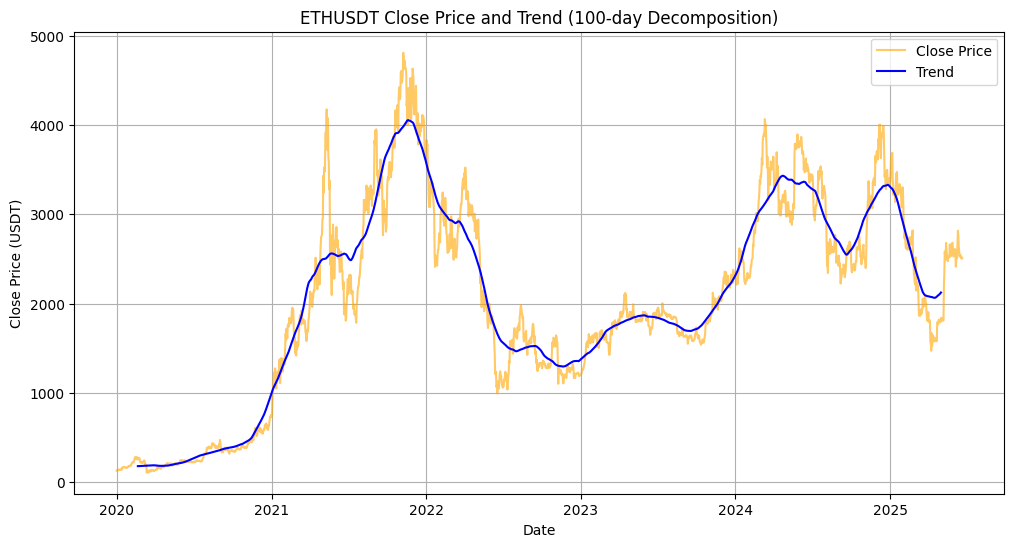

In [19]:
days = 100
decomposition = seasonal_decompose(eth_data["close"], model='additive', period=days)

trend = decomposition.trend

plt.figure(figsize=(12, 6))
plt.plot(eth_data.index,eth_data["close"], label='Close Price', color='orange',alpha = 0.6)
plt.plot(trend , label = "Trend", color='blue')
plt.title(f'ETHUSDT Close Price and Trend ({days}-day Decomposition)')
plt.xlabel('Date')
plt.ylabel('Close Price (USDT)')
plt.legend()
plt.grid(True)
plt.savefig("graphs/eth_trend_decomposition.png")
plt.show()

Seasonality Over time

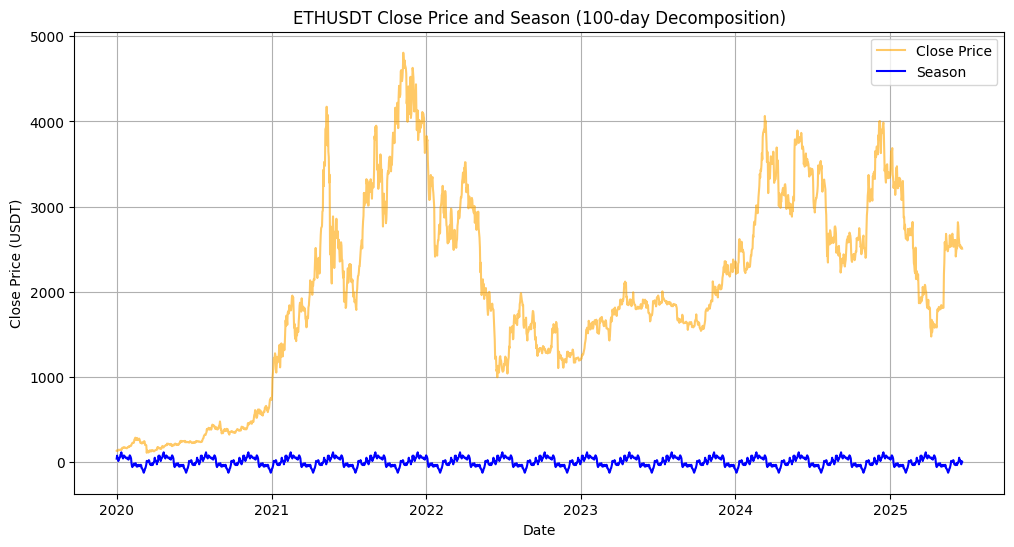

In [20]:
season = decomposition.seasonal

plt.figure(figsize=(12, 6))
plt.plot(eth_data.index,eth_data["close"], label='Close Price', color='orange',alpha = 0.6)
plt.plot(season , label = "Season", color='blue')
plt.title(f'ETHUSDT Close Price and Season ({days}-day Decomposition)')
plt.xlabel('Date')
plt.ylabel('Close Price (USDT)')
plt.legend()
plt.grid(True)
plt.savefig("graphs/eth_season_decomposition.png")
plt.show()

### Step 4: Stationary Testing

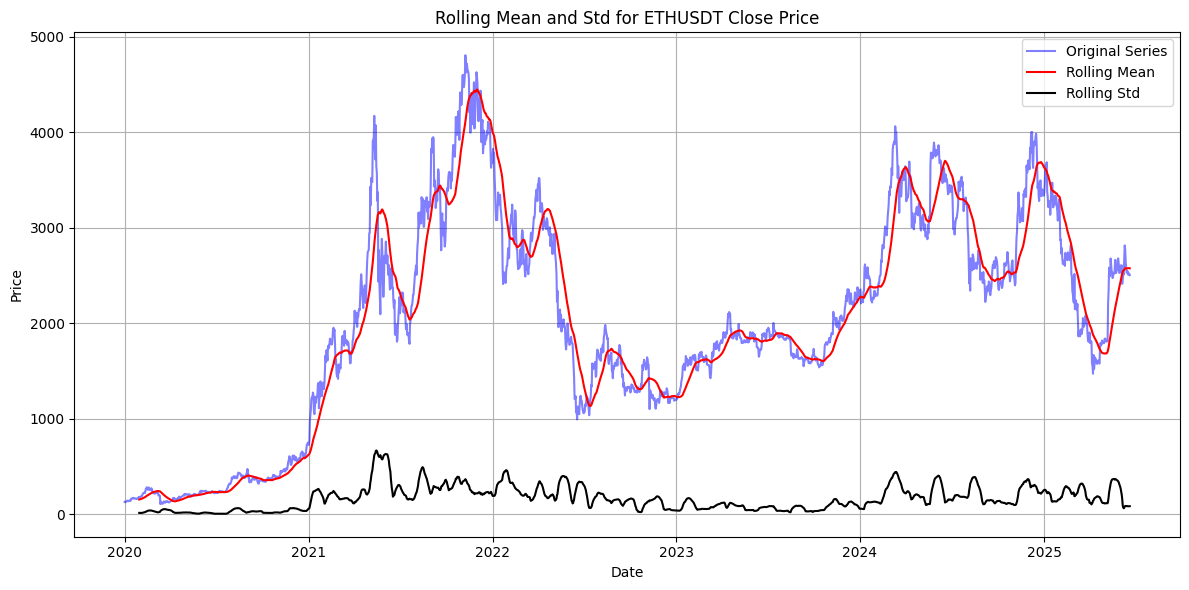

In [9]:
def plot_rolling_stats(series , window = 30, title = ""):
    rolmean = series.rolling(window=window).mean()
    rolstd = series.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, color='blue', label='Original Series',alpha = 0.5)
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title(f'Rolling Mean and Std for {title}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"graphs/eth_rolling_stats_{title}.png")
    plt.show()

plot_rolling_stats(eth_data["close"], window=30, title="ETHUSDT Close Price")

### Interpretaion:
The rolling statistics analysis of Ethereum’s closing price shows that the rolling mean remains close to the original series over time, with no strong upward or downward drift. The rolling standard deviation also remains relatively stable, except for spikes during high-volatility periods. This indicates that the series may exhibit stationarity or at least weak trend non-stationarity. However, formal statistical testing (ADF test) is required to confirm this.


### ADF Testing

In [24]:
def adf_test(series,title = ""):
    print(f"Augmented Dickey-Fuller Test for {title}")
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', '#Observations Used']
    for value, label in zip(result[:4], labels):
        print(f'{label}: {value}')
    print("Critial Values: ")
    for key,value in result[4].items():
        print(f"   {key} : {value}")
    
    if result[1] <= 0.05:
        print("✅ The series is stationary (reject H0)")
    else:
        print("❌ The series is non-stationary (fail to reject H0)")
    
adf_test(eth_data["close"], title="ETHUSDT Close Price")

Augmented Dickey-Fuller Test for ETHUSDT Close Price
ADF Statistic: -2.16934186635289
p-value: 0.21756011249391966
#Lags Used: 17
#Observations Used: 1980
Critial Values: 
   1% : -3.433656968706682
   5% : -2.863000832624789
   10% : -2.567547686205489
❌ The series is non-stationary (fail to reject H0)


The series is non-stationary so we will apply differencing to make it stationary


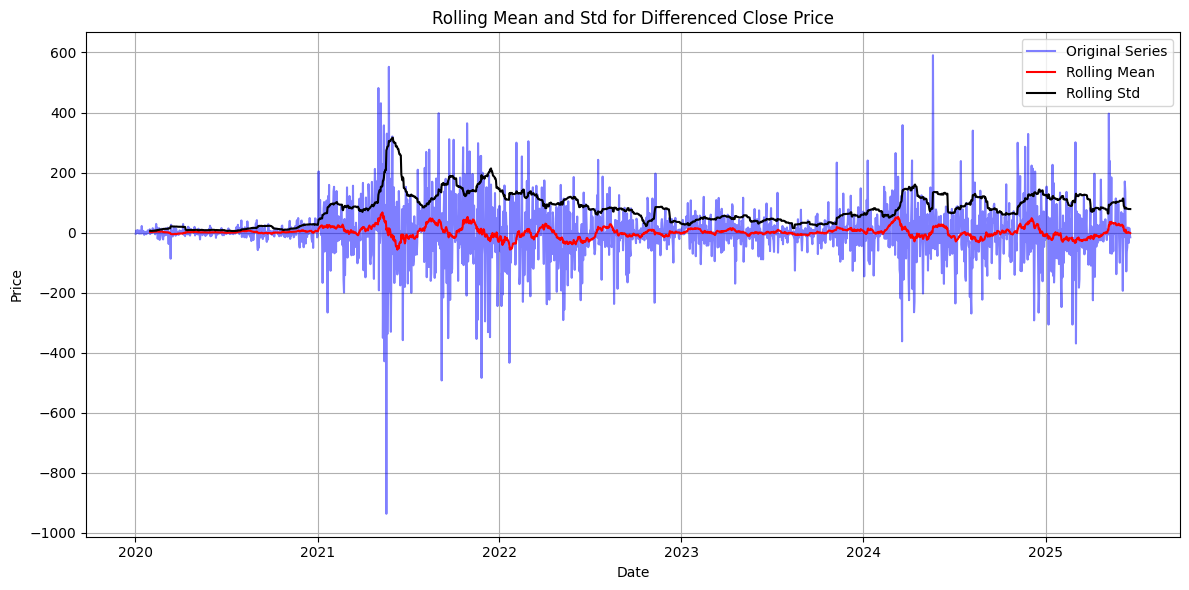

Augmented Dickey-Fuller Test for Differenced Close Price
ADF Statistic: -11.078452348217098
p-value: 4.372104128957645e-20
#Lags Used: 16
#Observations Used: 1980
Critial Values: 
   1% : -3.433656968706682
   5% : -2.863000832624789
   10% : -2.567547686205489
✅ The series is stationary (reject H0)


In [11]:
eth_data["close_diff"] = eth_data["close"] - eth_data["close"].shift(1)
plot_rolling_stats(eth_data["close_diff"], title="Differenced Close Price")
adf_test(eth_data["close_diff"], title="Differenced Close Price")

Now the series is stationaryand we can proceed with the model traning.

### Step 5: ARIMA Model Training and Evaluation of the Model


We’ll use the differenced close price series for model fitting.

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

target_series = eth_data['close_diff'].dropna()


Plot ACF and PACF to select p and q for ARIMA MODEL

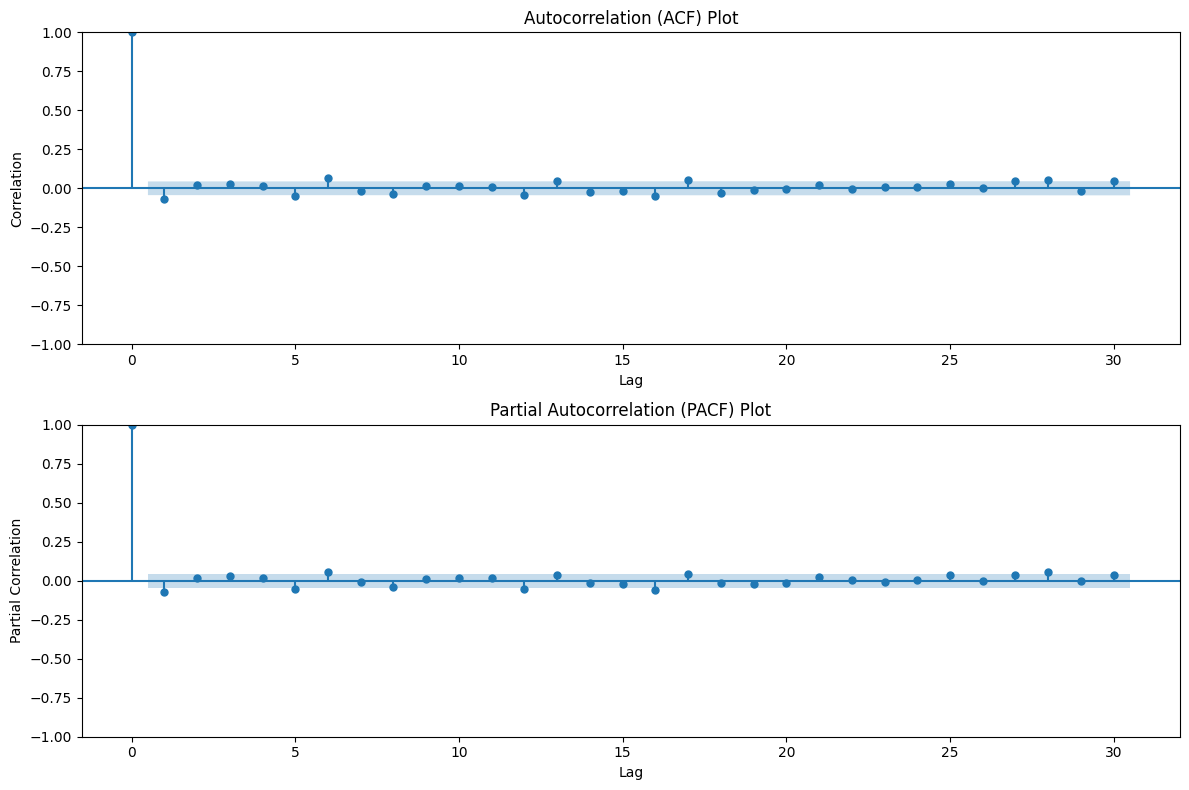

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))

plot_acf(target_series, ax=ax[0], lags=30)
ax[0].set_title("Autocorrelation (ACF) Plot")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Correlation")

plot_pacf(target_series, ax=ax[1], lags=30, method='ywm')
ax[1].set_title("Partial Autocorrelation (PACF) Plot")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Correlation")

plt.tight_layout()
plt.savefig("graphs/acf_pacf_plots.png")
plt.show()

Here we can see the cutoff points in both ACF and PACF plots are at Lag 1. At lag 1 correlation is suddenly drops from 1 to near zero. So we choose the values of p and q as 1 and 1 respectively.


Split data into training and testing sets


In [20]:
split_point = int(len(eth_data) * 0.8)
train_data = eth_data[:split_point]
test_data = eth_data[split_point:]

In [21]:
print(f"Train Data : {train_data.shape}")
print(f"Test Data : {test_data.shape}")

Train Data : (1598, 8)
Test Data : (400, 8)


Here I will fit different models with different hyper parameters and check their performance. The I will choose the best model and use it for prediction.


In [22]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt


def fit_arima(p,d,q,train_data,test_data,plot = True):
    if d==0:
        trend = 'c'
    elif d==1:
        trend = 't'
    else:
        trend = 'n'
        
    print(f"Fitting and Evaluating ARIMA ({p},{d},{q})")
    
    model = ARIMA(train_data["close"] , order = (p,d,q),trend = trend)
    model_fit = model.fit()

    forecast = model_fit.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

    rsme= np.sqrt(mean_squared_error(test_data['close'],forecast))
    mape = mean_absolute_percentage_error(test_data['close'], forecast)*100

    print(f"RMSE: {rsme:.4f}")
    print(f"MAPE: {mape:.2f}%")

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(train_data.index, train_data['close'], label='Train Data', color='blue')
        plt.plot(test_data.index, test_data['close'], label='Test Data', color='orange')
        plt.plot(test_data.index, forecast, label='Predicted (Model Output)', color='green')
        plt.title(f'ARIMA({p},{d},{q}) Forecast vs Actual')
        plt.xlabel('Date')
        plt.ylabel('Differenced Close Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"graphs/arima_{p}_{d}_{q}_forecast.png")
        plt.show()
    
    return {
        "order" : (p, d, q),
        "rmse": rsme,
        "mape" : mape,
        "model_fit": model_fit
    }

Fitting and Evaluating ARIMA (1,1,1)


c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 908.4758
MAPE: 32.27%


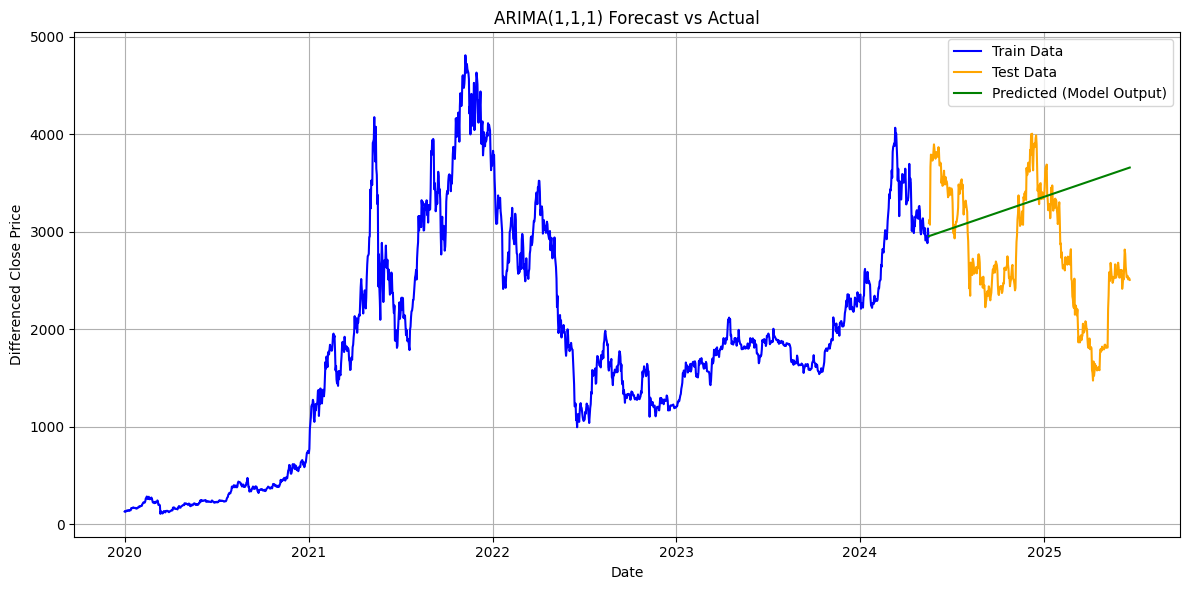

Fitting and Evaluating ARIMA (3,1,2)


c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting M

RMSE: 915.5910
MAPE: 32.54%


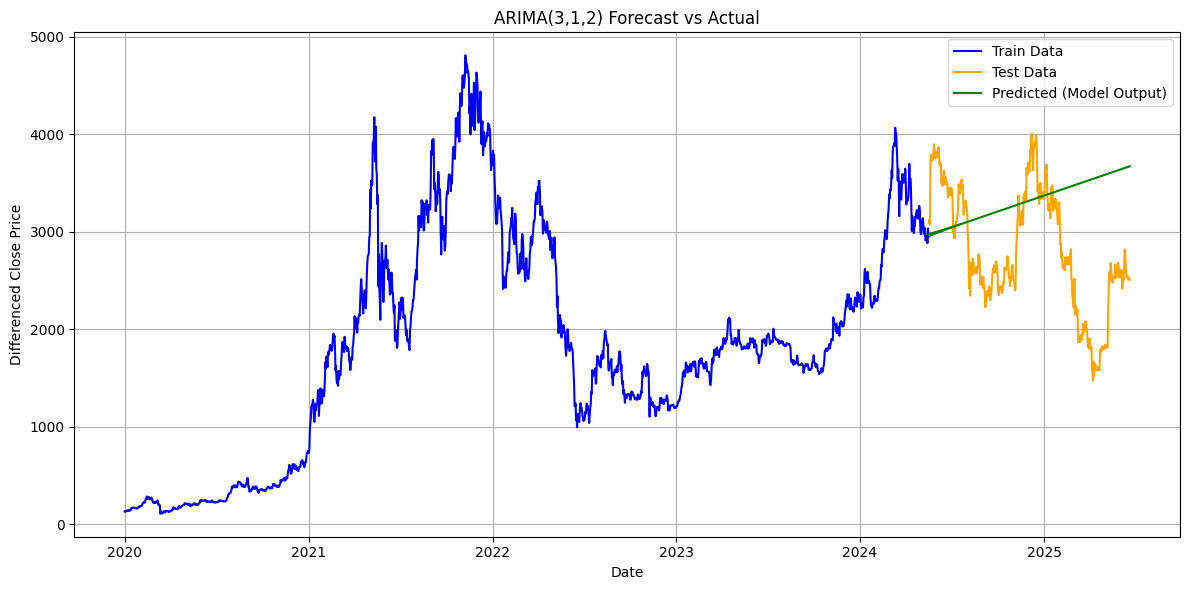

Fitting and Evaluating ARIMA (5,1,1)


c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 909.4306
MAPE: 32.31%


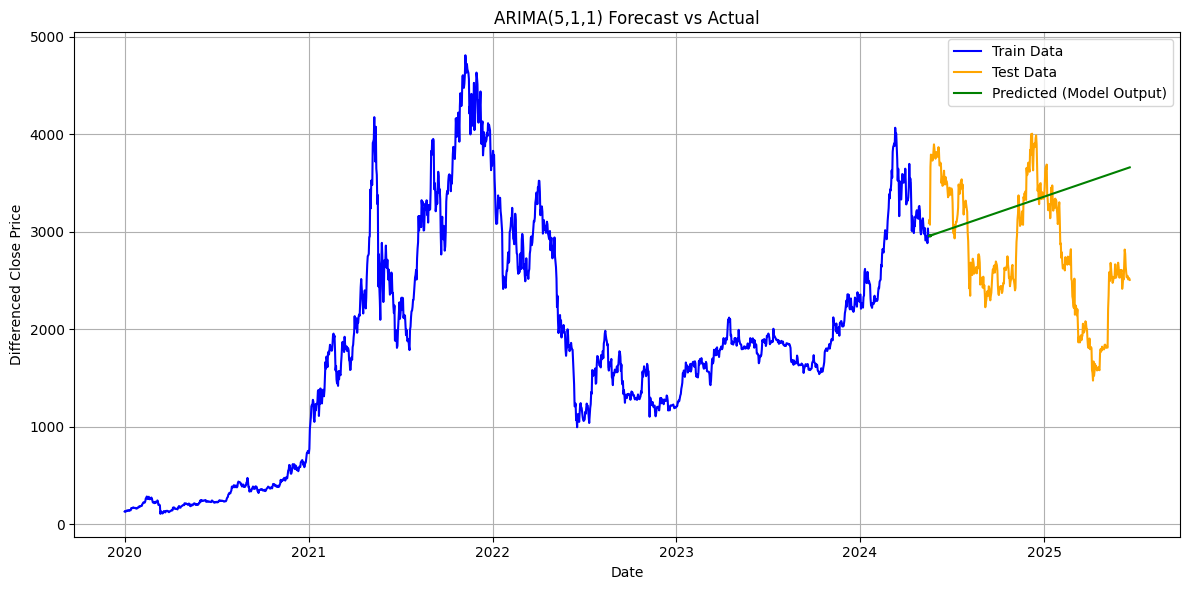

Fitting and Evaluating ARIMA (6,1,2)


c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 910.4604
MAPE: 32.34%


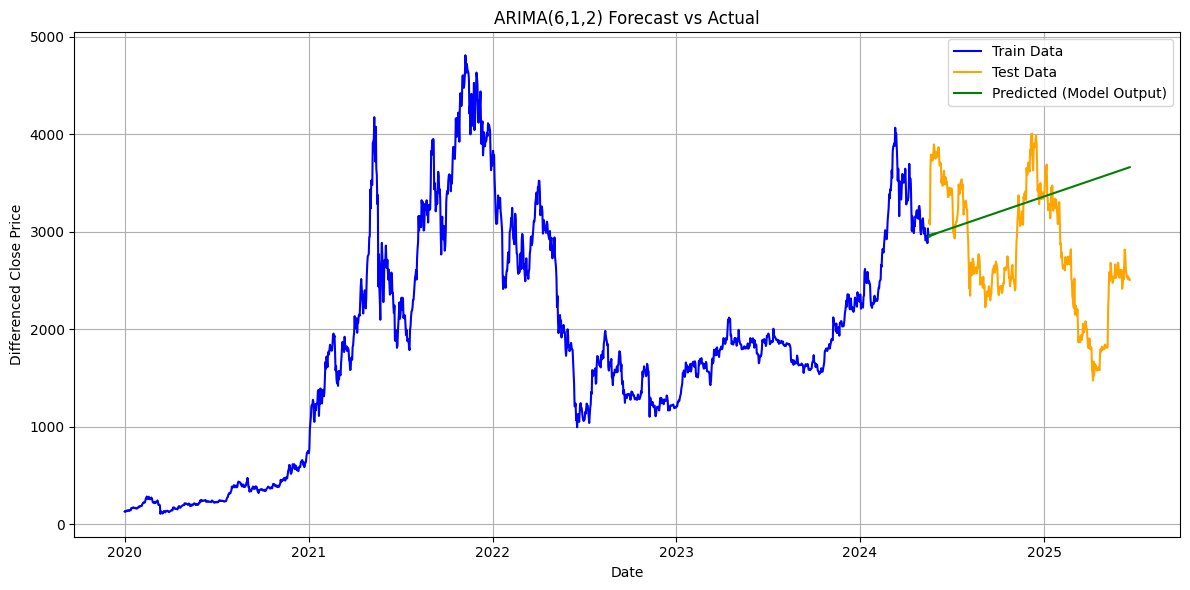

Fitting and Evaluating ARIMA (6,0,2)


c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 609.1737
MAPE: 17.30%


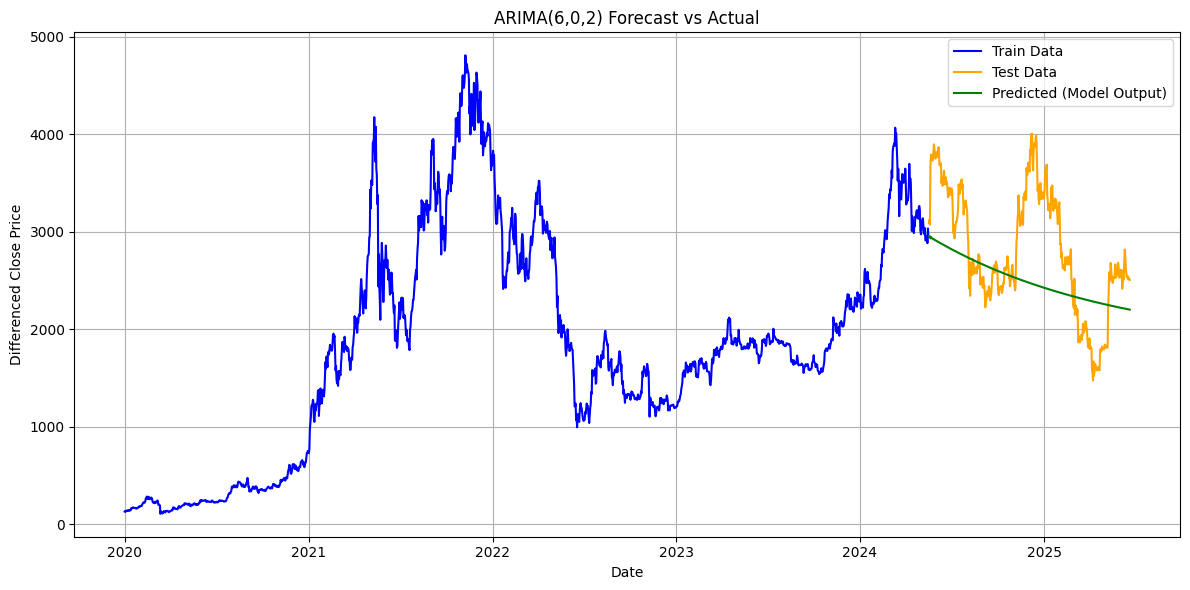

In [25]:
results = []

parameters = [(1, 1, 1), (3, 1, 2), (5, 1, 1), (6, 1, 2), (6, 0, 2)]

for parameters in parameters:
    result = fit_arima(*parameters, train_data, test_data, plot=True)
    if result:
        results.append(result)

Select the best model out the bests

In [26]:
best_result = min(results, key=lambda x: x["mape"])
best_order = best_result["order"]
best_model_fit = best_result["model_fit"]

print(f"\n✅ Best ARIMA Order: {best_order}")
print(f"RMSE: {best_result['rmse']:.4f}")
print(f"MAPE: {best_result['mape']:.2f}%")
print(f"AIC : {best_model_fit.aic:.2f}")
print(f"BIC : {best_model_fit.bic:.2f}")


✅ Best ARIMA Order: (6, 0, 2)
RMSE: 609.1737
MAPE: 17.30%
AIC : 18983.56
BIC : 19037.33


# Step 6 : 30-Days Forecast


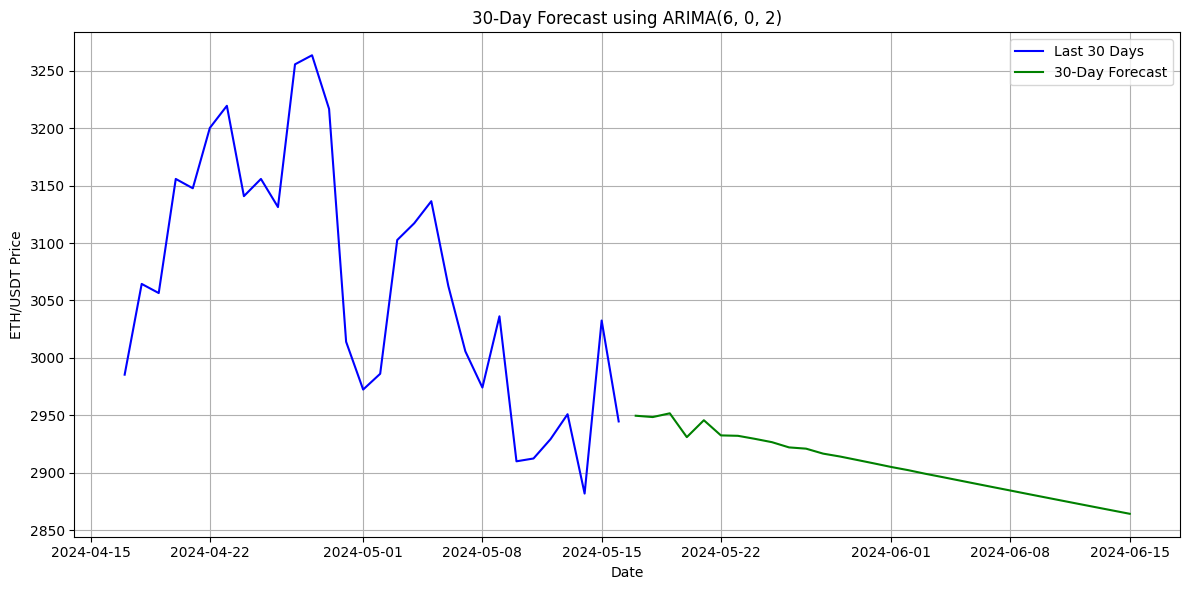

In [27]:
forecast_steps = 30
future_forecast = best_model_fit.get_forecast(steps=forecast_steps)

last_date = train_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)
forecast_mean = future_forecast.predicted_mean

plt.figure(figsize=(12,6))
plt.plot(train_data.index[-30:], train_data['close'].iloc[-30:], label="Last 30 Days", color='blue')
plt.plot(future_dates, forecast_mean, label="30-Day Forecast", color='green')
plt.title(f"30-Day Forecast using ARIMA{best_order}")
plt.xlabel("Date")
plt.ylabel("ETH/USDT Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"graphs/arima_{best_order[0]}_{best_order[1]}_{best_order[2]}_30day_forecast.png")
plt.show()